<a href="https://colab.research.google.com/github/musama00/Product-Demand-Prediction-Using-Machine-Learning-FYP-/blob/main/Regression_Models_(Product_Demand_Prediction_FYP)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [ ]:
train = pd.read_csv('/content/train.csv')
stores = pd.read_csv('/content/stores.csv')
features = pd.read_csv('/content/features.csv')
train = train.merge(stores, on='Store', how = 'left')
train = train.merge(features, on= ['Store', 'Date'], how='left')
# Selecting the required columns from the train DataFrame
selected_columns = ['Store', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Renaming 'IsHoliday_x' to 'Holiday_Flag' to match the required column names
df = train[selected_columns].rename(columns={'IsHoliday_x': 'Holiday_Flag'})

df['Holiday_Flag'] = df['Holiday_Flag'].astype(int)

df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")

# Display the modified DataFrame
# data.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Weekly_Sales  421570 non-null  float64       
 3   Holiday_Flag  421570 non-null  int64         
 4   Temperature   421570 non-null  float64       
 5   Fuel_Price    421570 non-null  float64       
 6   CPI           421570 non-null  float64       
 7   Unemployment  421570 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 25.7 MB


In [ ]:
df.describe()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,2011-06-18 08:30:31.963375104,15981.258123,0.070358,60.090059,3.361027,171.201947,7.960289
min,1.000000,2010-02-05 00:00:00,-4988.940000,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,11.000000,2010-10-08 00:00:00,2079.650000,0.000000,46.680000,2.933000,132.022667,6.891000
50%,22.000000,2011-06-17 00:00:00,7612.030000,0.000000,62.090000,3.452000,182.318780,7.866000
75%,33.000000,2012-02-24 00:00:00,20205.852500,0.000000,74.280000,3.738000,212.416993,8.572000
max,45.000000,2012-10-26 00:00:00,693099.360000,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.785297,NaN,22711.183519,0.255750,18.447931,0.458515,39.159276,1.863296


In [ ]:
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [ ]:
# Convert Date to datetime and extract features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day

# Drop the original Date column
df.drop('Date', axis=1, inplace=True)

# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Check for outliers
# numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
# df[numeric_cols].boxplot()
# plt.xticks(rotation=45)
# plt.show()

Duplicate rows: 95


In [ ]:
#Appying ML Models on Store 1 only
# Filter data for Store 1
df = df[df["Store"] == 1]

In [ ]:
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
0,1,24924.50,0,42.31,2.572,211.096358,8.106,2010,2,5,5
1,1,46039.49,1,38.51,2.548,211.242170,8.106,2010,2,6,12
2,1,41595.55,0,39.93,2.514,211.289143,8.106,2010,2,7,19
3,1,19403.54,0,46.63,2.561,211.319643,8.106,2010,2,8,26
4,1,21827.90,0,46.50,2.625,211.350143,8.106,2010,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...
10239,1,20.06,0,80.49,3.638,222.305480,6.908,2012,8,35,31
10240,1,0.05,1,83.96,3.730,222.439015,6.908,2012,9,36,7
10241,1,0.03,0,74.97,3.717,222.582019,6.908,2012,9,37,14
10242,1,635.00,0,68.55,3.617,223.181477,6.573,2012,10,40,5


In [ ]:
# Create lag features for time series
df.sort_values(['Store', 'Year', 'Month', 'Week'], inplace=True)
for lag in [1, 2, 3, 4]:
    df[f'Weekly_Sales_lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)


# Create rolling statistics
df['Weekly_Sales_rolling_mean_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(4).mean())
df['Weekly_Sales_rolling_std_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.rolling(4).std())

# Drop rows with NaN values created by lag features
df.dropna(inplace=True)

In [ ]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_3,Weekly_Sales_lag_4,Weekly_Sales_rolling_mean_4,Weekly_Sales_rolling_std_4
572,1,32229.38,0,42.31,2.572,211.096358,8.106,2010,2,5,5,39954.04,13740.12,50605.27,24924.50,34132.2025,15542.559923
715,1,5749.03,0,42.31,2.572,211.096358,8.106,2010,2,5,5,32229.38,39954.04,13740.12,50605.27,22918.1425,15873.830334
858,1,21084.08,0,42.31,2.572,211.096358,8.106,2010,2,5,5,5749.03,32229.38,39954.04,13740.12,24754.1325,14850.137144
1001,1,40129.01,0,42.31,2.572,211.096358,8.106,2010,2,5,5,21084.08,5749.03,32229.38,39954.04,24797.8750,14909.971340
1144,1,16930.99,0,42.31,2.572,211.096358,8.106,2010,2,5,5,40129.01,21084.08,5749.03,32229.38,20973.2775,14318.661075


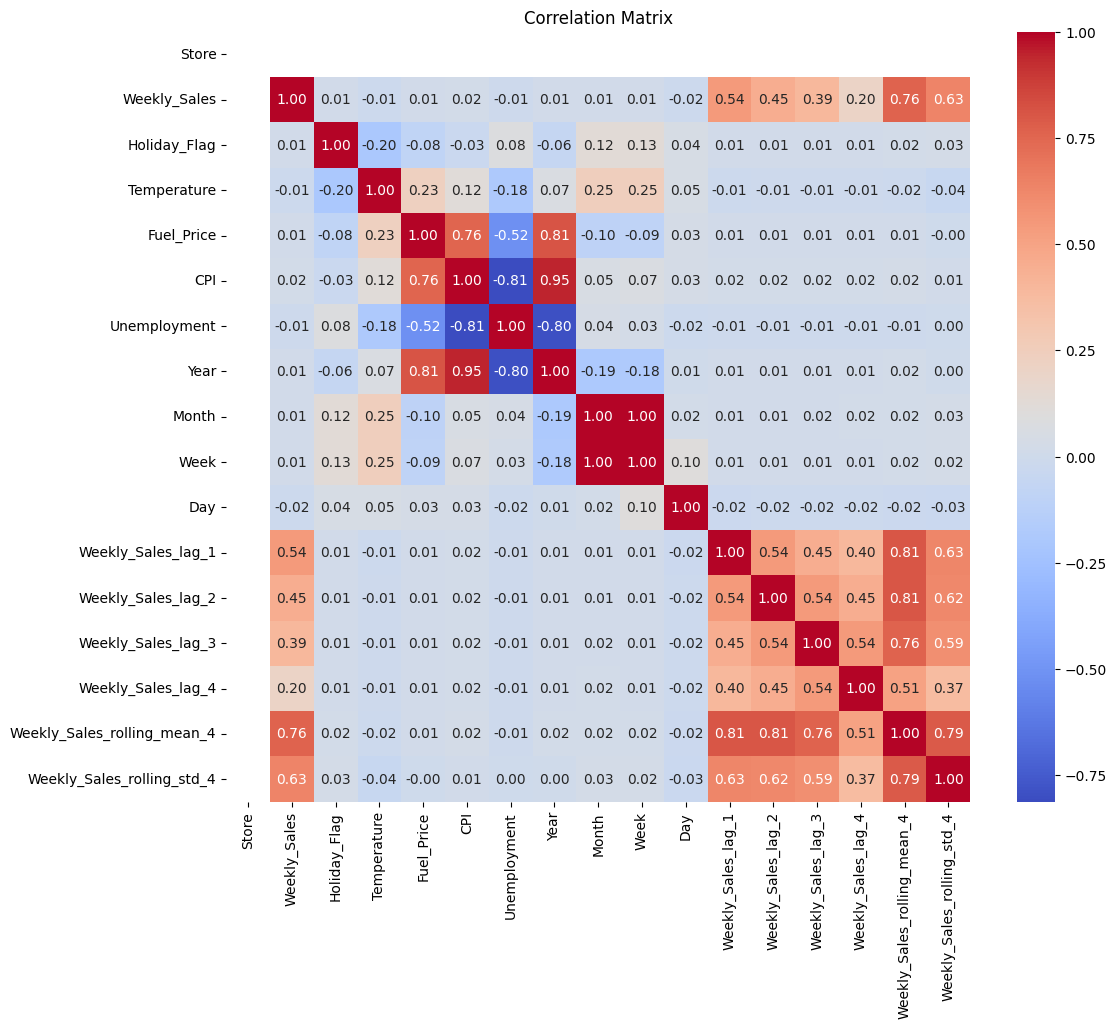

Weekly_Sales                   1.000000
Weekly_Sales_rolling_mean_4    0.760831
Weekly_Sales_rolling_std_4     0.633509
Weekly_Sales_lag_1             0.541869
Weekly_Sales_lag_2             0.450038
Weekly_Sales_lag_3             0.394863
Weekly_Sales_lag_4             0.200200
CPI                            0.018047
Month                          0.014609
Holiday_Flag                   0.013239
Year                           0.013045
Week                           0.013000
Fuel_Price                     0.011613
Unemployment                  -0.008872
Temperature                   -0.012614
Day                           -0.019665
Store                               NaN
Name: Weekly_Sales, dtype: float64
Selected features: ['Weekly_Sales_rolling_mean_4', 'Weekly_Sales_rolling_std_4', 'Weekly_Sales_lag_1', 'Weekly_Sales_lag_2', 'Weekly_Sales_lag_3', 'Weekly_Sales_lag_4']


In [ ]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Select features with highest correlation to Weekly_Sales
corr_with_target = corr_matrix['Weekly_Sales'].sort_values(ascending=False)
print(corr_with_target)

# Select top correlated features
selected_features = corr_with_target[abs(corr_with_target) > 0.1].index.tolist()
selected_features.remove('Weekly_Sales')
print("Selected features:", selected_features)

In [ ]:
# Split into features and target
X = df[selected_features]
y = df['Weekly_Sales']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

print("Random Forest Results:")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"R2 Score: {r2_score(y_test, y_pred_rf)}")

Random Forest Results:
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE: 3345.781572653595
R2 Score: 0.9861450611420474


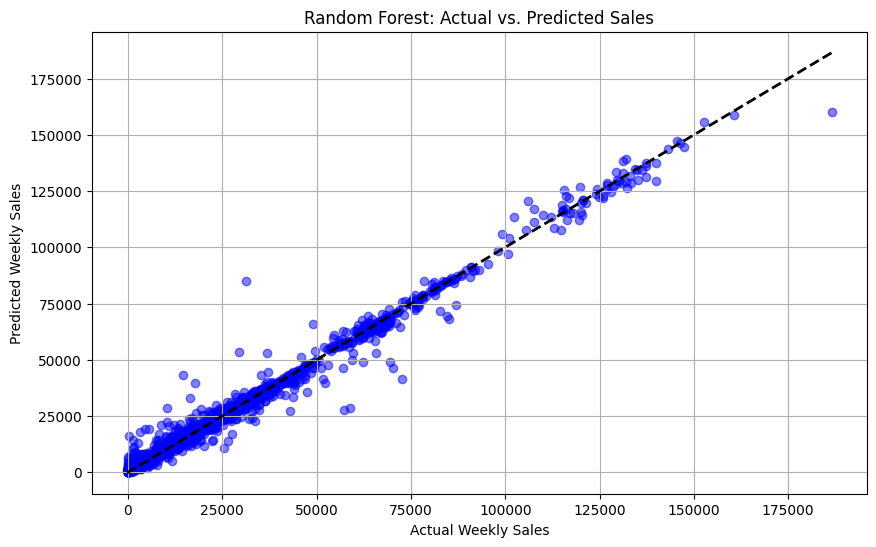

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('Random Forest: Actual vs. Predicted Sales')
plt.grid(True)
plt.show()

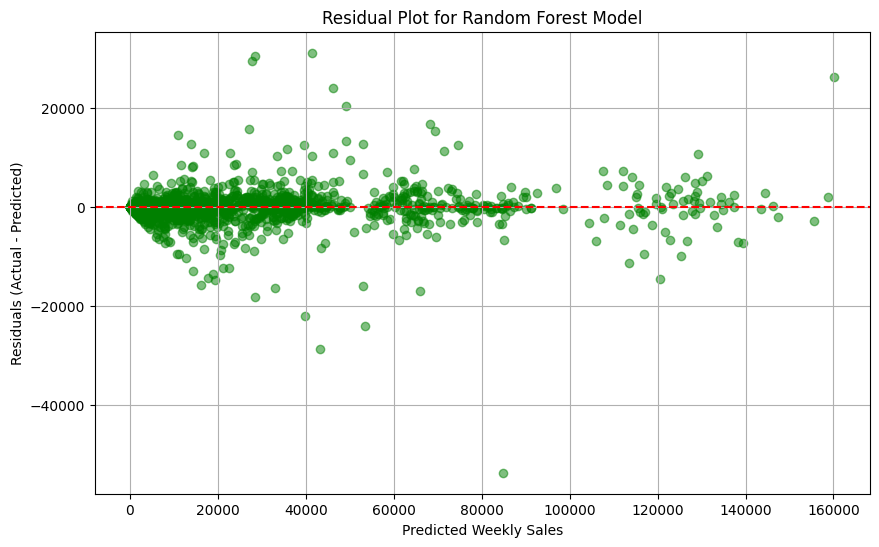

In [ ]:
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Random Forest Model')
plt.grid(True)
plt.show()

In [ ]:
# XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)

best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)

print("\nXGBoost Results:")
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb))}")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb)}")


XGBoost Results:
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
RMSE: 2491.11389722156
R2 Score: 0.9923193740927608


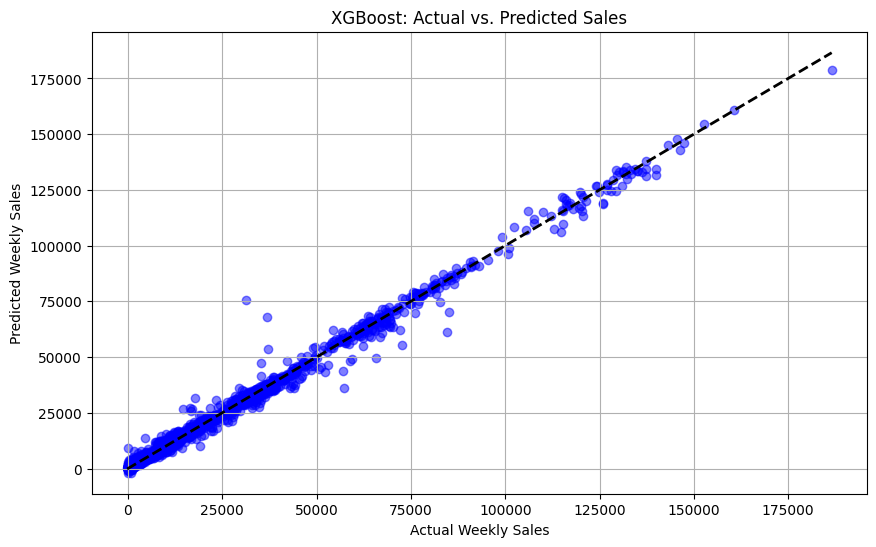

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('XGBoost: Actual vs. Predicted Sales')
plt.grid(True)
plt.show()

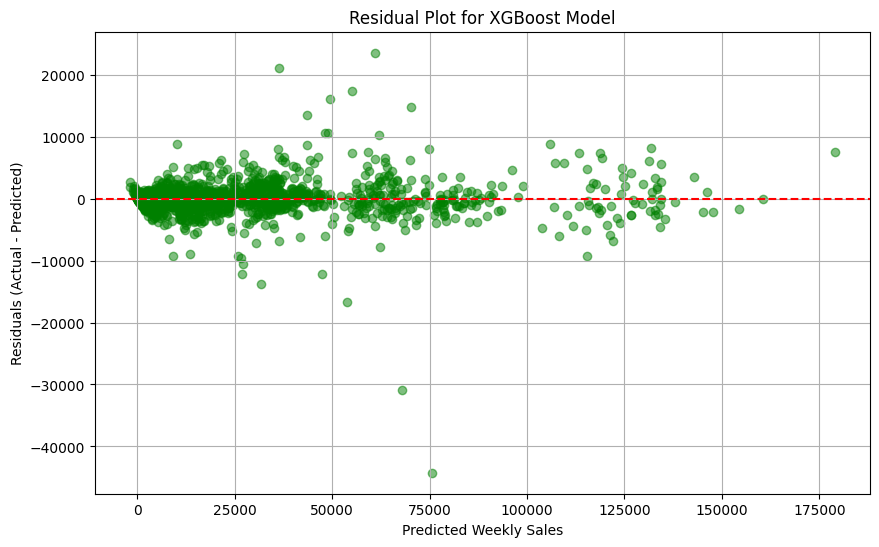

In [ ]:

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_xgb
plt.scatter(y_pred_xgb, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for XGBoost Model')
plt.grid(True)
plt.show()

In [ ]:
# AdaBoost
ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

ada = AdaBoostRegressor(random_state=42)
ada_grid = GridSearchCV(ada, ada_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ada_grid.fit(X_train_scaled, y_train)

best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test_scaled)

print("\nAdaBoost Results:")
print(f"Best Parameters: {ada_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ada))}")
print(f"R2 Score: {r2_score(y_test, y_pred_ada)}")


AdaBoost Results:
Best Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
RMSE: 12139.428159803629
R2 Score: 0.817607950913691


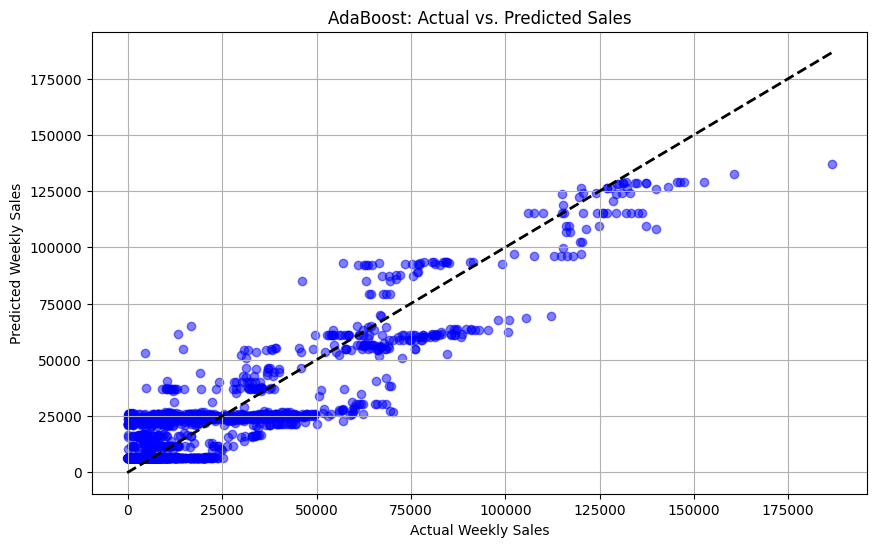

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ada, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('AdaBoost: Actual vs. Predicted Sales')
plt.grid(True)
plt.show()


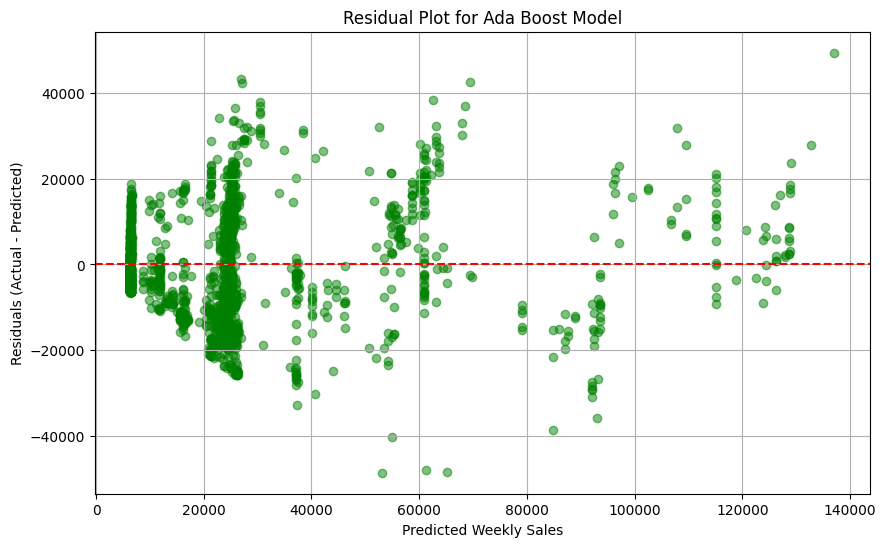

In [ ]:
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_ada
plt.scatter(y_pred_ada, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Ada Boost Model')
plt.grid(True)
plt.show()

In [ ]:
# Gradient Boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)

best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test_scaled)

print("\nGradient Boosting Results:")
print(f"Best Parameters: {gb_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gb))}")
print(f"R2 Score: {r2_score(y_test, y_pred_gb)}")


Gradient Boosting Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
RMSE: 2804.414405825377
R2 Score: 0.9902659444019994


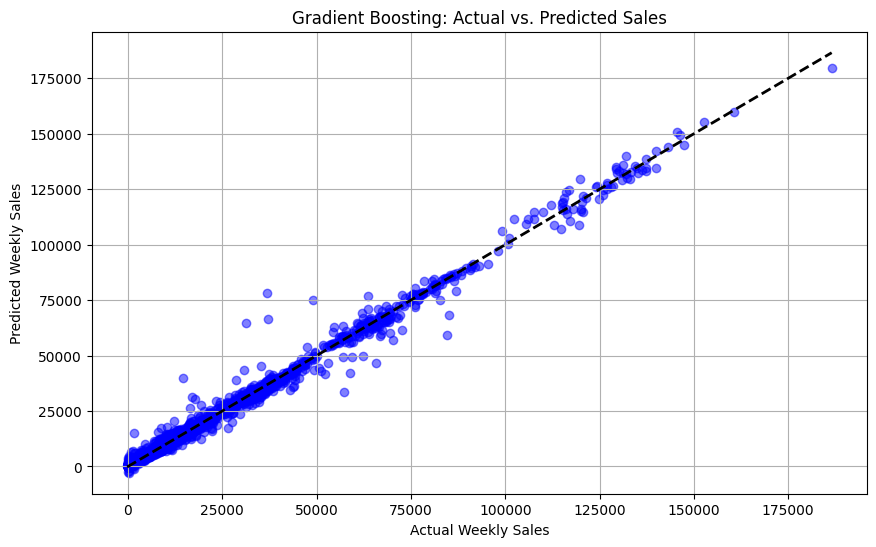

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('Gradient Boosting: Actual vs. Predicted Sales')
plt.grid(True)
plt.show()

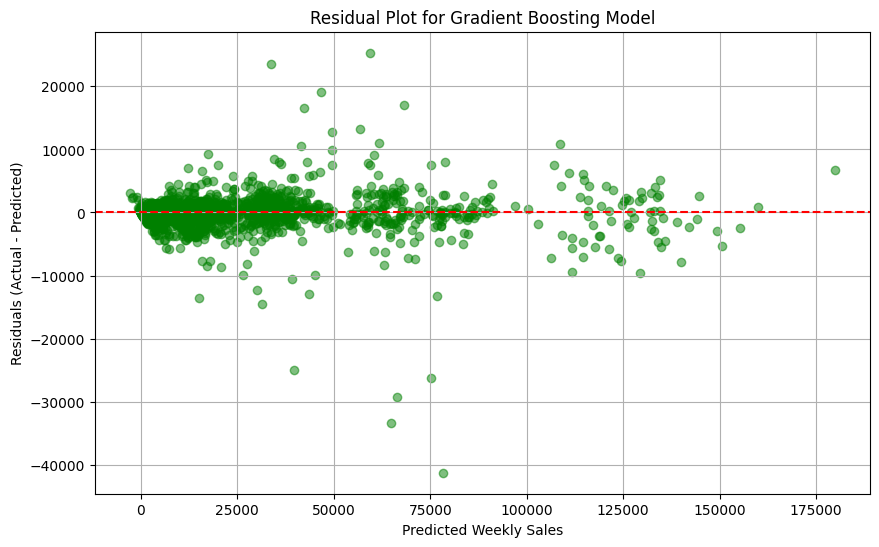

In [ ]:


plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_gb
plt.scatter(y_pred_gb, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for Gradient Boosting Model')
plt.grid(True)
plt.show()

In [ ]:
# Support Vector Regressor
svr_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5]
}

svr = SVR()
svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train)

best_svr = svr_grid.best_estimator_
y_pred_svr = best_svr.predict(X_test_scaled)

print("\nSVR Results:")
print(f"Best Parameters: {svr_grid.best_params_}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_svr))}")
print(f"R2 Score: {r2_score(y_test, y_pred_svr)}")


SVR Results:
Best Parameters: {'C': 10, 'epsilon': 0.5, 'kernel': 'linear'}
RMSE: 18704.603222179347
R2 Score: 0.5669815074386066


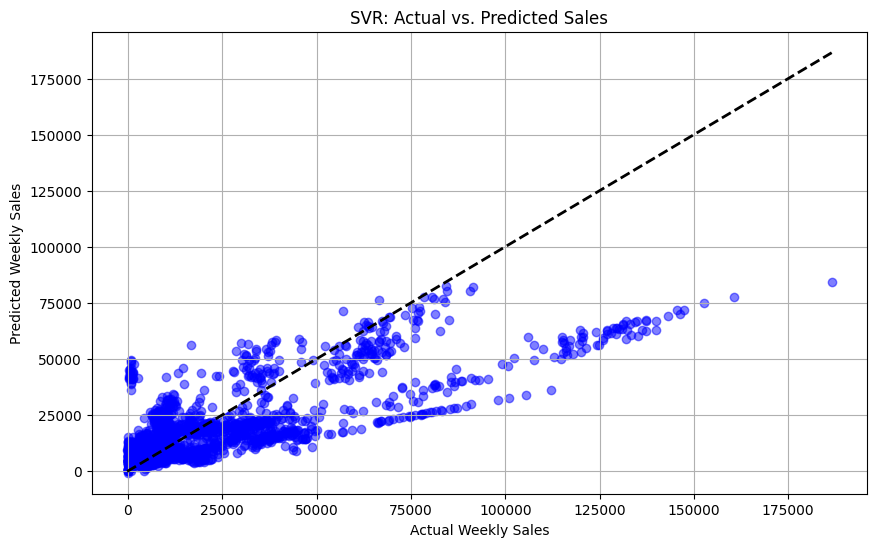

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.title('SVR: Actual vs. Predicted Sales')
plt.grid(True)
plt.show()

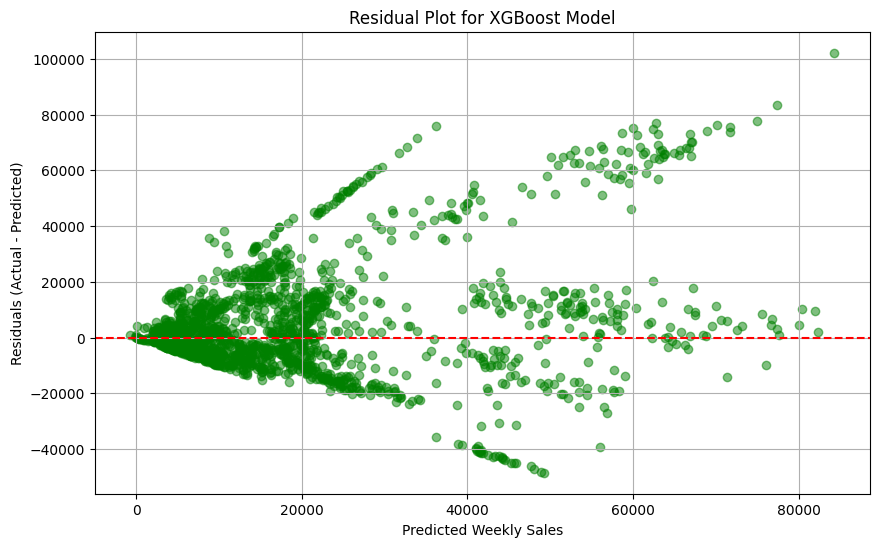

In [ ]:


plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_svr
plt.scatter(y_pred_svr, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Weekly Sales')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot for XGBoost Model')
plt.grid(True)
plt.show()

In [ ]:
# Neural Network
#mlp_params = {
 #   'hidden_layer_sizes': [(50,), (100,), (50, 50)],
  #  'activation': ['relu', 'tanh'],
   # 'alpha': [0.0001, 0.001, 0.01],
    #'learning_rate': ['constant', 'adaptive']
#}

#mlp = MLPRegressor(random_state=42, max_iter=1000)
#mlp_grid = GridSearchCV(mlp, mlp_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#mlp_grid.fit(X_train_scaled, y_train)

#best_mlp = mlp_grid.best_estimator_
#y_pred_mlp = best_mlp.predict(X_test_scaled)

#print("\nNeural Network Results:")
#print(f"Best Parameters: {mlp_grid.best_params_}")
#print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_mlp))}")
#print(f"R2 Score: {r2_score(y_test, y_pred_mlp)}")

In [ ]:
#plt.figure(figsize=(10, 6))
#plt.scatter(y_test, y_pred_mlp, alpha=0.5, color='blue')
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#plt.xlabel('Actual Weekly Sales')
#plt.ylabel('Predicted Weekly Sales')
#plt.title('XGBoost: Actual vs. Predicted Sales')
#plt.grid(True)
#plt.show()

In [ ]:


#plt.figure(figsize=(10, 6))
#residuals = y_test - y_pred_mlp
#plt.scatter(y_pred_mlp, residuals, alpha=0.5, color='green')
#plt.axhline(y=0, color='r', linestyle='--')
#plt.xlabel('Predicted Weekly Sales')
#plt.ylabel('Residuals (Actual - Predicted)')
#plt.title('Residual Plot for XGBoost Model')
#plt.grid(True)
#plt.show()

In [ ]:
# Collect all model results
models = {
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'AdaBoost': best_ada,
    'Gradient Boosting': best_gb,
    'SVR': best_svr,
    #'Neural Network': best_mlp
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2 Score': r2})

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values('RMSE'))


Model Comparison:
               Model          RMSE  R2 Score
1            XGBoost   2491.113897  0.992319
3  Gradient Boosting   2804.414406  0.990266
0      Random Forest   3345.781573  0.986145
2           AdaBoost  12139.428160  0.817608
4                SVR  18704.603222  0.566982


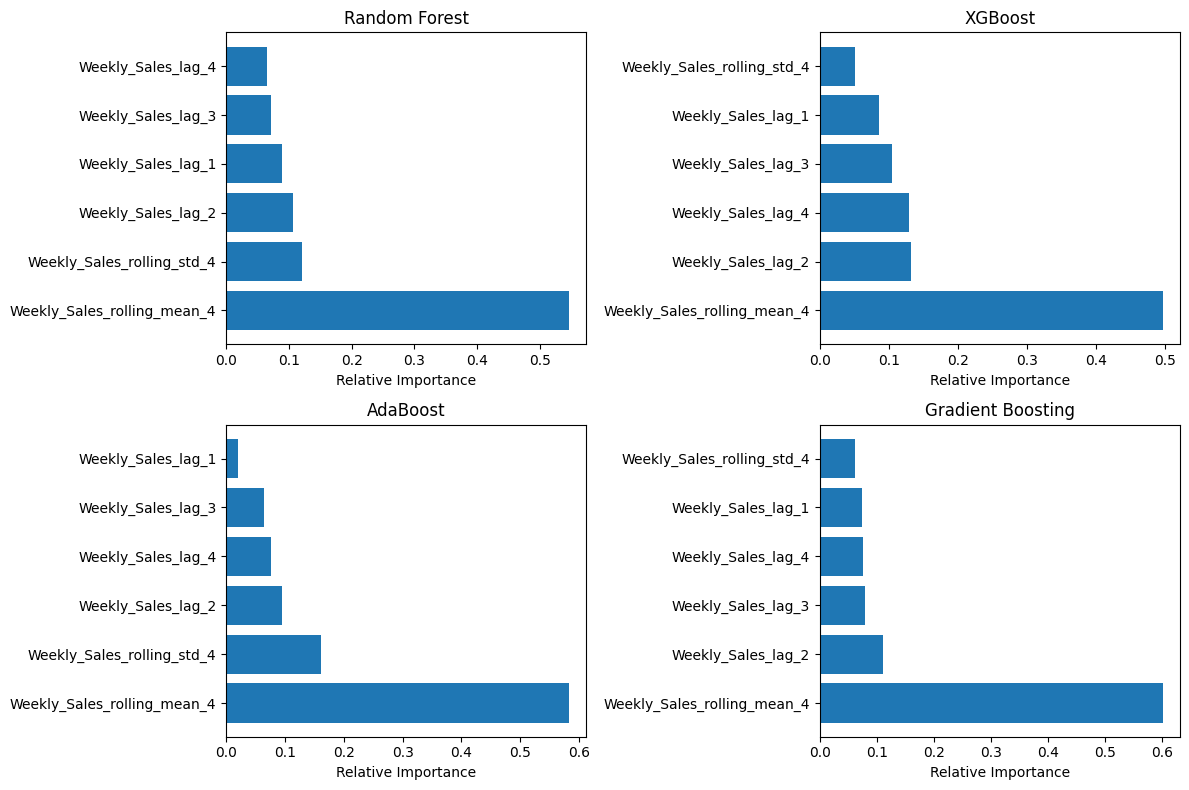

In [ ]:
# Plot feature importance for tree-based models
plt.figure(figsize=(12, 8))
for i, (name, model) in enumerate(models.items()):
    if hasattr(model, 'feature_importances_'):
        plt.subplot(2, 2, i+1)
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.title(name)
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
        plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

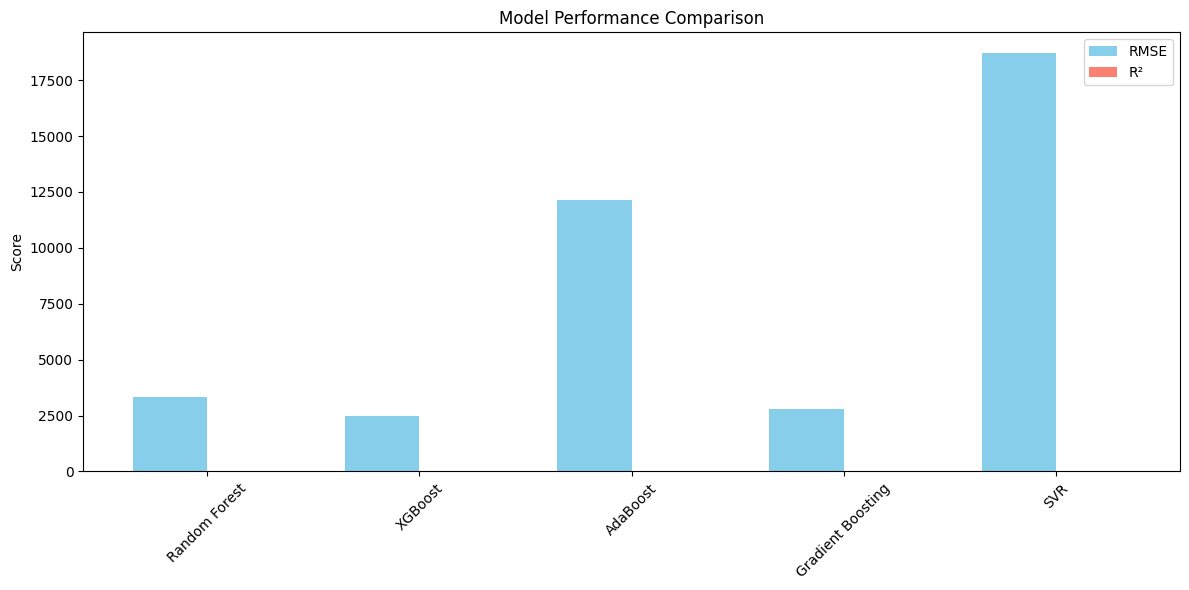

In [ ]:
metrics = ['RMSE', 'R2']
models = ['Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'SVR']
rmse_values = [np.sqrt(mean_squared_error(y_test, y_pred_rf)),
               np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
               np.sqrt(mean_squared_error(y_test, y_pred_ada)),
               np.sqrt(mean_squared_error(y_test, y_pred_gb)),
               np.sqrt(mean_squared_error(y_test, y_pred_svr))]
r2_values = [r2_score(y_test, y_pred_rf),
             r2_score(y_test, y_pred_xgb),
             r2_score(y_test, y_pred_ada),
             r2_score(y_test, y_pred_gb),
             r2_score(y_test, y_pred_svr)]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
rects2 = ax.bar(x + width/2, r2_values, width, label='R²', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
import joblib
import os

# Create a directory to store models if it doesn't exist
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)


# Dictionary of all trained models
models = {
    'RandomForest': best_rf,
    'XGBoost': best_xgb,
    'AdaBoost': best_ada,
    'GradientBoosting': best_gb,
    'SVR': best_svr,
}

# Save each model and its scaler
for model_name, model in models.items():
    # Save the model
    joblib.dump(model, f'{output_dir}/{model_name}_model.pkl')

    # Save the scaler (same scaler for all models in this case)
    joblib.dump(scaler, f'{output_dir}/{model_name}_scaler.pkl')

    print(f"Saved {model_name} model and scaler.")


Saved RandomForest model and scaler.
Saved XGBoost model and scaler.
Saved AdaBoost model and scaler.
Saved GradientBoosting model and scaler.
Saved SVR model and scaler.


In [ ]:
# Example: Load and use a specific model (e.g., RandomForest)
loaded_model = joblib.load(f'{output_dir}/RandomForest_model.pkl')
loaded_scaler = joblib.load(f'{output_dir}/RandomForest_scaler.pkl')

# Sample prediction
sample_data = X_test.iloc[0:1]  # Get one sample
scaled_sample = loaded_scaler.transform(sample_data)
prediction = loaded_model.predict(scaled_sample)
print(f"\nRandomForest prediction: {prediction[0]}")
print(f"Actual value: {y_test.iloc[0]}")


RandomForest prediction: 25.205900000000042
Actual value: 4.88
